# Time Series Model Validation Demo

## Import Libraries 

In [1]:
# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

# System libraries
import glob
import os
import pickle

# ML libraries
import pandas as pd

# ValidMind libraries 
import validmind as vm

## Load Time Series Models

In [2]:
models_folder = '../models/time_series/'
model_files = os.listdir(models_folder)

models = {}

for model_file in model_files:
    if model_file.endswith('.pkl'):
        model_name = os.path.splitext(model_file)[0]
        with open(os.path.join(models_folder, model_file), 'rb') as f:
            models[model_name] = pickle.load(f)

## Load Training Datasets

Get the training dataset from one of the models.

In [3]:
model_fit = models['fred_loan_rates_model_1']

In [4]:
# Extract the endogenous (target) variable from the model fit
train_df = pd.Series(model_fit.model.endog, index=model_fit.model.data.row_labels)
train_df = train_df.to_frame()
target_var_name = model_fit.model.endog_names
train_df.columns = [target_var_name]

# Extract the exogenous (explanatory) variables from the model fit
exog_df = pd.DataFrame(model_fit.model.exog, index=model_fit.model.data.row_labels, columns=model_fit.model.exog_names)

# Concatenate the endogenous (target) and exogenous (explanatory) variables
train_df = pd.concat([train_df, exog_df], axis=1)
train_df.head()

,MORTGAGE30US,FEDFUNDS
DATE,,
1971-05-01,0.17,0.47
1971-06-01,0.08,0.28
1971-07-01,0.15,0.40
1971-08-01,0.00,0.26
1971-09-01,-0.02,-0.02


In [5]:
train_df.tail()

,MORTGAGE30US,FEDFUNDS
DATE,,
2012-06-01,-0.09,0.00
2012-07-01,-0.17,0.00
2012-08-01,0.10,-0.03
2012-09-01,-0.19,0.01
2012-10-01,0.01,0.02


## Load Test Datasets

Load raw test dataset.

In [6]:
file = '../datasets/time_series/fred_loan_rates_test_1.csv'
raw_test_df = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')
display(raw_test_df)

,MORTGAGE30US,UNRATE,GS10,FEDFUNDS
DATE,,,,
2012-11-01,3.32,7.7,1.65,0.16
2012-12-01,3.35,7.9,1.72,0.16
2013-01-01,3.53,8.0,1.91,0.14
2013-02-01,3.51,7.7,1.98,0.15
2013-03-01,3.57,7.5,1.96,0.14
...,...,...,...,...
2022-11-01,6.58,3.6,3.89,3.78
2022-12-01,6.42,3.5,3.62,4.10
2023-01-01,6.13,3.4,3.53,4.33


Transform raw test dataset using same transformation used in the train dataset. 

In [7]:
transform_func = 'diff'
if transform_func == 'diff':
    test_df = raw_test_df.diff().dropna()

## ValidMind Setup

In [8]:
vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "e22b89a6b9c2a27da47cb0a09febc001",
  api_secret = "a61be901b5596e3c528d94231e4a3c504ef0bb803d16815f8dfd6857fac03e57",
  project = "clgo0g0rt0000fjy6ozl9pb69"
)

True

In [9]:
vm_train_ds = vm.init_dataset(dataset=train_df, type="generic")
vm_test_ds = vm.init_dataset(dataset=test_df, type="generic")

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


## Run Time Series Forecast Test Plan

Describe test plan.

In [10]:
vm.test_plans.describe_plan("time_series_forecast")

Attribute,Value
ID,time_series_forecast
Name,TimeSeriesForecast
Description,Test plan to perform time series forecast tests.
Required Context,"['models', 'test_ds']"
Tests,ModelPredictionOLS (Metric)
Test Plans,[]


In [11]:
config= {
    "model_prediction_ols": {
        "model_fits_dict": models
    }
}

Create vm models. 

In [12]:
vm_model_1 = vm.init_model(models['fred_loan_rates_model_1'])
vm_model_3 = vm.init_model(models['fred_loan_rates_model_3'])
list_of_models = [vm_model_1, vm_model_3]


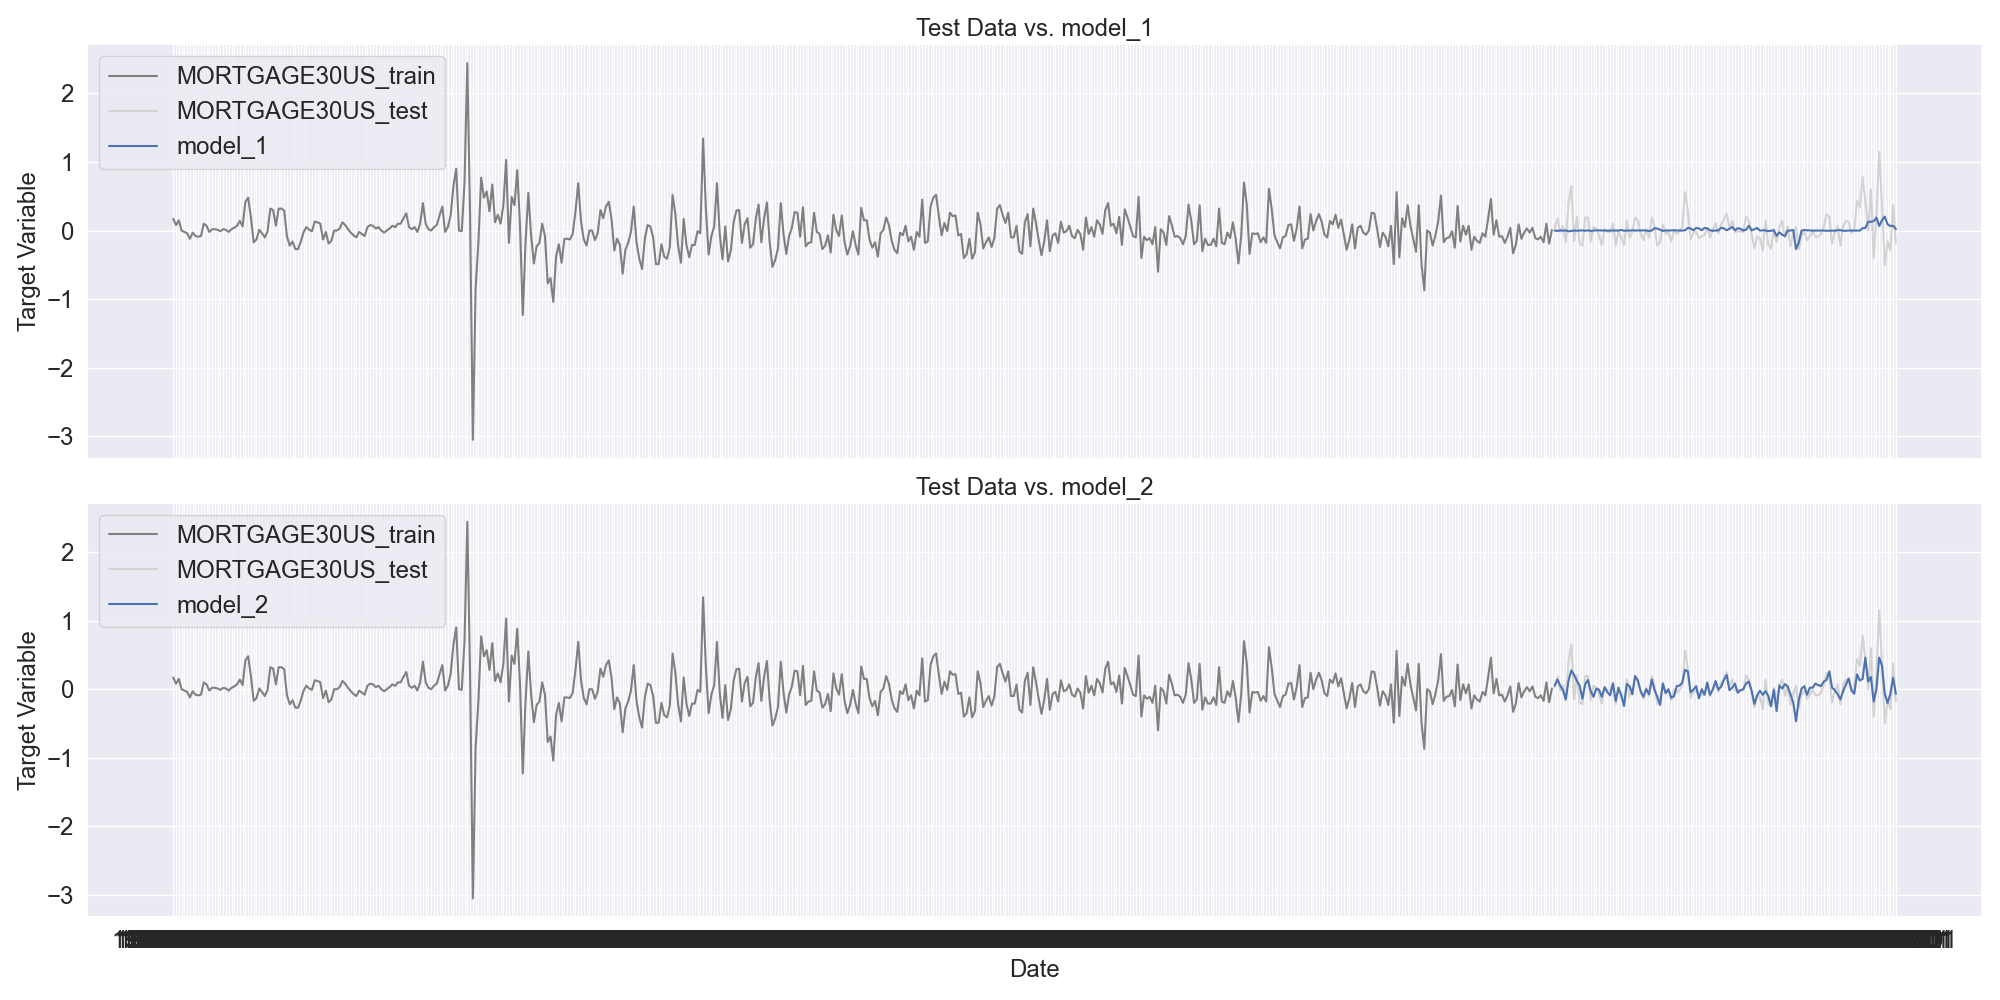

TimeSeriesForecast(test_context=TestContext(dataset=None, model=None, models=[Model(attributes=ModelAttributes(architecture=None, framework=None, framework_version=None), task=None, subtask=None, params=None, model_id='main', model=<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x107297310>), Model(attributes=ModelAttributes(architecture=None, framework=None, framework_version=None), task=None, subtask=None, params=None, model_id='main', model=<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x107297ac0>)], train_ds=None, test_ds=Dataset(raw_dataset=            MORTGAGE30US  UNRATE  GS10  FEDFUNDS
DATE                                            
2012-12-01          0.03     0.2  0.07      0.00
2013-01-01          0.18     0.1  0.19     -0.02
2013-02-01         -0.02    -0.3  0.07      0.01
2013-03-01          0.06    -0.2 -0.02     -0.01
2013-04-01         -0.17     0.1 -0.20      0.01
...                  ...     ...   ...       ...
2022

In [13]:
vm.run_test_plan("time_series_forecast",
                                        models=list_of_models,
                                        test_ds=vm_test_ds)